<a href="https://colab.research.google.com/github/ManuelGehl/IMPRS-Introduction-to-Neural-Networks-2023/blob/main/Chapter_3_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 3 - Convolutional Neural Network

In the previous chapter, we saw how an ANN can learn the patterns of a grayscale image. The image was flattened into a 1D array and this array was fed into the ANN. Although this approach worked very well on the MNIST dataset, it is not very suitable for real-world problems because it ignores the internal (2D) structure of an image.


In this chapter, we will cover the following topics:
* How are color images represented in the computer?
* How are color images used as input to an ANN?
* How can we use convolution to preserve the internal structure of images?

The workflow in this chapter is also a typical workflow you would use for real-world problems:

1. Inspect data
2. Preprocessing data
3. Use a small portion of the dataset to screen different models
4. Compare different models on the test dataset
5. Optimize the best model and train it on the entire dataset


# Check for GPU

The datasets in the previous chapters were small enough to run the models on the CPU. Now we will be working with a larger dataset and will need access to a GPU.

In [1]:
# Check for GPU
!nvidia-smi

Fri Oct 13 13:23:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load and inspect the Malaria dataset

We will first run all experiments on 10% of the data and then train our best model on 100% of the data. This **upscaling** approach has the advantage of reducing computation time for large datasets.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import seaborn as sns
sns.set_style()

In [3]:
# Prepare the dataset
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
tf.random.set_seed(42)

# Load full dataset and split it into 70%:30% train and test dataset
(validation_dataset, train_dataset, test_dataset), info = tfds.load(
    'malaria',
    split=["train[:10%]","train[10%:70%]", "train[70%:100%]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    )

# Take 10% of the train dataset for baseline models
shuffled_dataset = train_dataset.shuffle(buffer_size=len(train_dataset))
train_dataset_10 = shuffled_dataset.take(round(len(train_dataset) / 10))

# Check distribution of different datasets
num_train = len(train_dataset)
num_train_1 = len(train_dataset_10)
num_test = len(test_dataset)
num_validation = len(validation_dataset)
print(f"Samples in train_dataset: {num_train}")
print(f"Samples in train_dataset_10: {num_train_1}")
print(f"Samples in test_dataset: {num_test}")
print(f"Samples in validation_dataset: {num_validation}")
print(f"Samples overall: {num_train+num_test+num_validation}")
info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompletePX3FYV/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
Samples in train_dataset: 16535
Samples in train_dataset_10: 1654
Samples in test_dataset: 8267
Samples in validation_dataset: 2756
Samples overall: 27558


tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmp_h_i12h8tfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


**Now we check if the classes in train_dataset and train_dataset_10 are balanced.**

In [4]:
# Check if classes are balanced in train_dataset
counter = []
for image, label in train_dataset:
  counter.append(label.numpy())

print(f"Number of parazited images: {counter.count(0)} \nNumber of uninfected images: {counter.count(1)}")

Number of parazited images: 8289 
Number of uninfected images: 8246


In [5]:
# Check if classes are balanced in train_dataset_10
counter = []

for image, label in train_dataset_10:
  counter.append(label.numpy())

print(f"Number of parazited images: {counter.count(0)} \nNumber of uninfected images: {counter.count(1)}")

Number of parazited images: 828 
Number of uninfected images: 826


**Let's take a look at some of the images in the dataset.**

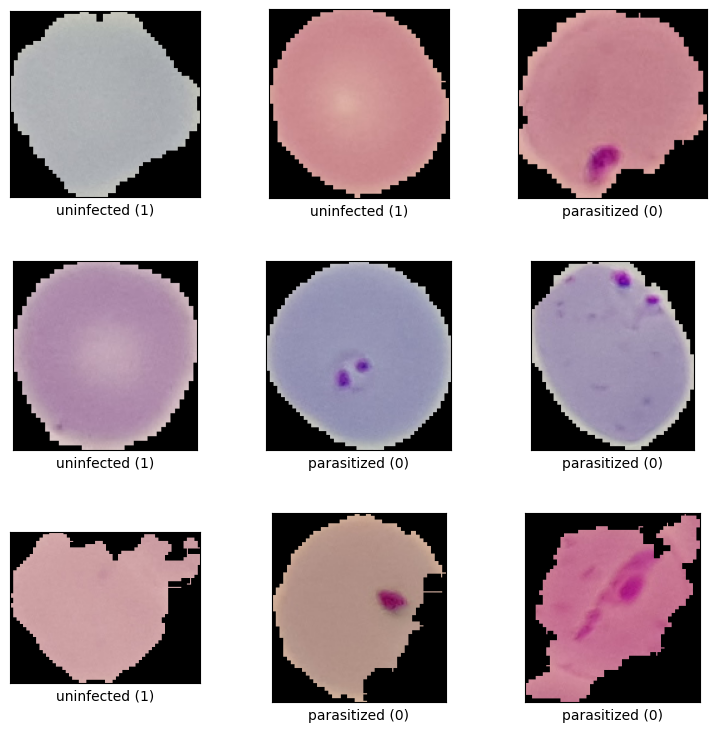

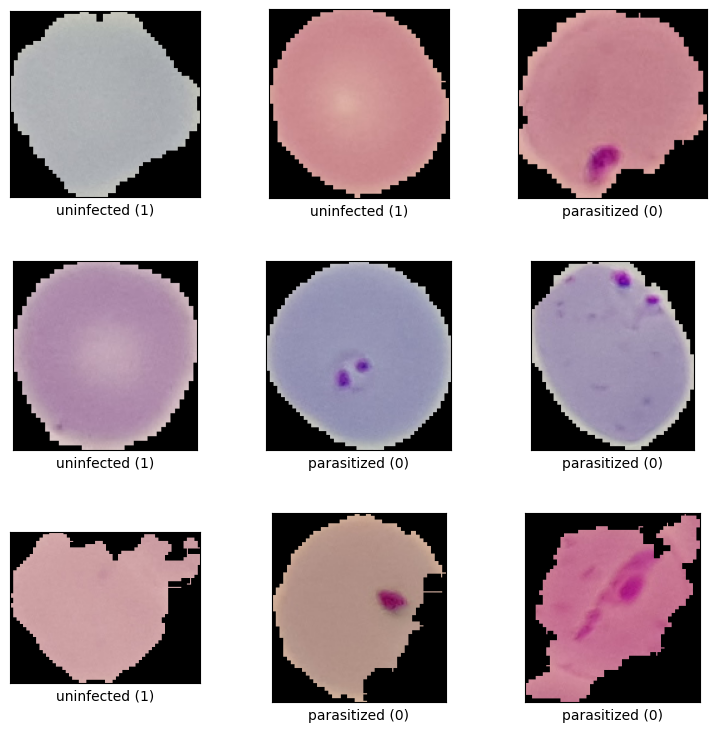

In [6]:
# Visualize some examples of the dataset
tfds.visualization.show_examples(train_dataset, info)

❓**Question**: Looking at the images, what do you think we need to do to preprocess the dataset before feeding it to an ANN?

In [7]:
# Check image shape of some images
sample_image = next(iter(train_dataset))[0]
print(f"Sample image shape: {sample_image.shape}")

Sample image shape: (145, 148, 3)


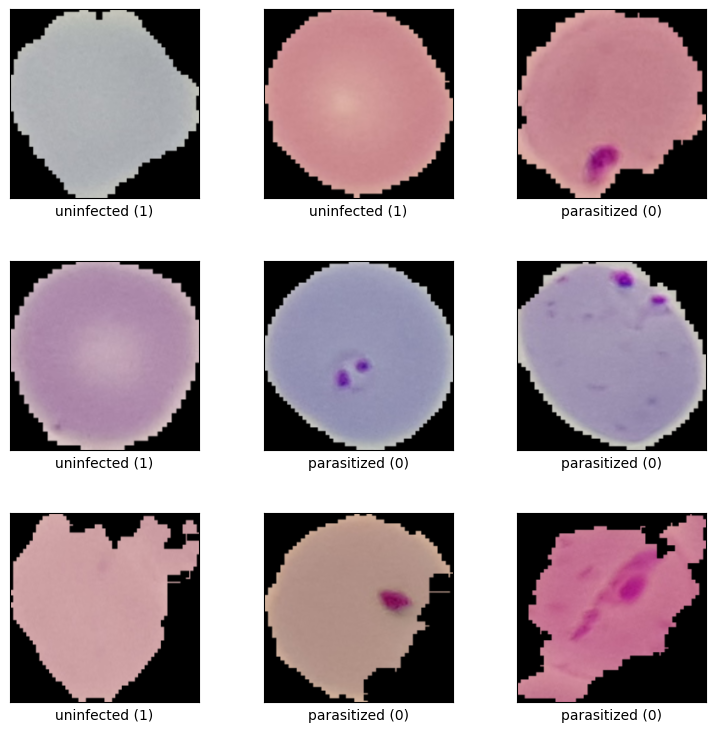

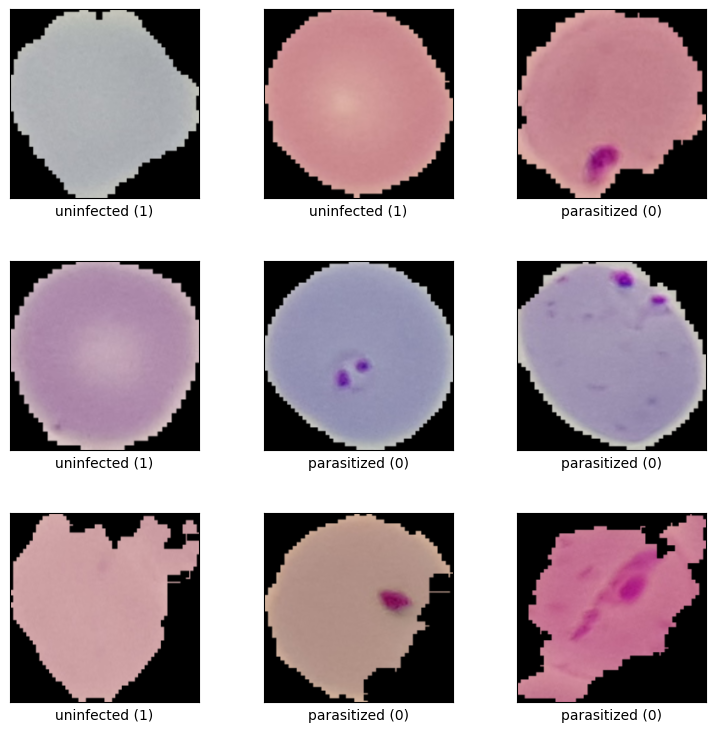

In [8]:
# Resize images, rescale them, and batch them
def transform_image(image, label):
  resized_image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
  transformed_image = tf.divide(resized_image, 255.0)
  return transformed_image, label

# Apply the resize function to the dataset
train_dataset = train_dataset.map(transform_image)
train_dataset_10 = train_dataset_10.map(transform_image)
test_dataset = test_dataset.map(transform_image)
validation_dataset = validation_dataset.map(transform_image)

tfds.visualization.show_examples(train_dataset, info)

In [9]:
# Check image shape of some images
sample_image = next(iter(train_dataset))[0]
print(f"Sample image shape: {sample_image.shape}")

Sample image shape: (224, 224, 3)


**Now we will perform some additional preprocessing steps to speed up data handling, i.e. batching and prefetching our dataset.**

In [10]:
# Batch and prefetch dataset
tf.random.set_seed(42)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset_10 = train_dataset_10.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [11]:
# Check image tensor dimensions
sample_image = next(iter(train_dataset))[0]
print(f"Sample image shape: {sample_image.shape}")

Sample image shape: (32, 224, 224, 3)


**Before we start modeling, let's create a lab book to track the different experiments.**

We will use 10% of the train dataset to save time. Virtually, we will upscale our best model and train it on the entire train dataset.

In [12]:
# Create a lab-book to track the different experiments
lab_book = {}

# Model 1 (Baseline):

- Best model from Chapter 2 - Classification
- Flatten layer to convert image tensor (224, 224, 3) into 1D tensor
- 2 Hidden layers of 16 neurons each (activation = ReLU)
- Output layer with 1 neuron (activation = sigmoid)

In [13]:
# Lab Book Name Entry
name = "Model 1"

# Build model
tf.random.set_seed(42)
model_1 = keras.Sequential([layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3)),
                            layers.Flatten(),
                            layers.Dense(16, activation="relu"),
                            layers.Dense(16, activation="relu"),
                            layers.Dense(1, activation="sigmoid")
                           ])

model_1.summary()

#  Compile the model
model_1.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=["accuracy"]
                )

# Fit the model
history_1 = model_1.fit(train_dataset_10, validation_data=validation_dataset, epochs=5)

# Write lab-book
lab_book[name] = history_1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 16)                2408464   
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2408753 (9.19 MB)
Trainable params: 2408753 (9.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
52/52 [==============================] - 28s 141ms/step - loss: 1.0047 - accuracy: 0.5012 - val_loss: 0.6932 - val_accuracy: 0.4906
Epoch 2/

# Model 2:
- Conv2D layer with 5 neurons/filters
- Flatten layer
- Output layer with 1 neuron (activation = sigmoid)

In [14]:
# Lab Book Name Entry
name = "CNN model 1"

# Build CNN model
tf.random.set_seed(42)
model_2 = keras.Sequential([layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
                            layers.Conv2D(filters=8,
                                          kernel_size=(3,3),
                                          strides=(1,1),
                                          activation="relu"),
                            layers.Flatten(),
                            layers.Dense(1, activation="sigmoid")
                            ])

model_2.summary()

# Compile CNN model
model_2.compile(loss=keras.losses.BinaryCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit CNN model
history_2 = model_2.fit(train_dataset_10, validation_data=validation_dataset, epochs=5)

# Write lab-book
lab_book[name] = history_2

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 flatten_1 (Flatten)         (None, 394272)            0         
                                                                 
 dense_3 (Dense)             (None, 1)                 394273    
                                                                 
Total params: 394497 (1.50 MB)
Trainable params: 394497 (1.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
52/52 [==============================] - 19s 75ms/step - loss: 2.0522 - accuracy: 0.5659 - val_loss: 0.6318 - val_accuracy: 0.6495
Epoch 2/5
52/52 [==============================] - 12s 67ms/step - loss: 0.6634 - accuracy: 0.6282 - val_loss: 0.6036 - val_accuracy: 0.6713


**Before we compare the performance of the baseline model (Model 1) and the CNN model (Model 2), take a look at the number of trainable parameters for these two models.**

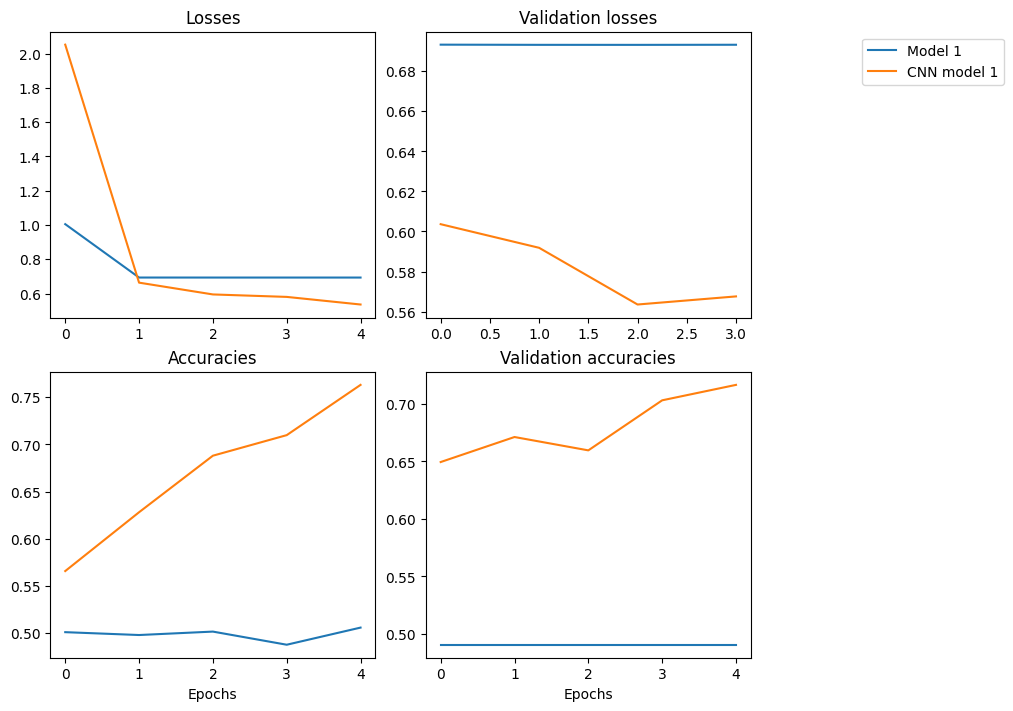

In [15]:
# Define function to compare the histories of different experiments from the lab-book
def plot_history(histories:dict):
  num_histories = len(histories)
  fig, ax = plt.subplots(2,2, figsize=(10,7), layout="constrained")
  ax[0,0].set_title("Losses")
  ax[0,1].set_title("Validation losses")
  ax[1,0].set_title("Accuracies")
  ax[1,1].set_title("Validation accuracies")
  ax[1,0].set_xlabel("Epochs")
  ax[1,1].set_xlabel("Epochs")

  for i in range (num_histories):
    keys = list(lab_book.keys())
    values = list(lab_book.values())
    ax[0,0].plot(values[i].history["loss"], label=keys[i])
    ax[0,1].plot(values[i].history["val_loss"][1:], label=keys[i])
    ax[1,0].plot(values[i].history["accuracy"], label=keys[i])
    ax[1,1].plot(values[i].history["val_accuracy"], label=keys[i])

  ax[0,1].legend(bbox_to_anchor=(1.8, 1))

# Visualize learning performance of our first two models
plot_history(lab_book)

# Model 3:

In general, the larger and more complex a dataset is, the larger and more complex a model must be to learn the underlying patterns.

Therefore, Model 3 consists of:

* 4 Conv2D layers, each with 8 filters
* 2 MaxPool2D layers
* 1 Dense layer of 128 neurons
* 1 output dense layer of 1 neuron

In [16]:
# Name the model
name = "CNN model 2"

# Build CNN model
tf.random.set_seed(42)
model_3 = keras.Sequential([layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
                            layers.Conv2D(filters=8,
                                           kernel_size=(3,3),
                                           strides=(1,1),
                                           activation="relu"),
                            layers.Conv2D(filters=8,
                                           kernel_size=(3,3),
                                           activation="relu"),
                            layers.MaxPool2D(pool_size=(2,2)),
                            layers.Conv2D(filters=8,
                                           kernel_size=(3,3),
                                           activation="relu"),
                            layers.Conv2D(filters=8,
                                           kernel_size=(3,3),
                                           activation="relu"),
                            layers.MaxPool2D(pool_size=(2,2)),
                            layers.Flatten(),
                            layers.Dense(128, activation="relu"),
                            layers.Dense(1, activation="sigmoid")
                            ])

model_3.summary()

# Compile CNN model
model_3.compile(loss=keras.losses.BinaryCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit CNN model
history_3 = model_3.fit(train_dataset_10, validation_data=validation_dataset, epochs=5)

# Write lab-book
lab_book[name] = history_3

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 8)       224       
                                                                 
 conv2d_2 (Conv2D)           (None, 220, 220, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 8)       0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 108, 108, 8)       584       
                                                                 
 conv2d_4 (Conv2D)           (None, 106, 106, 8)       584       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 8)         0         
 g2D)                                                 

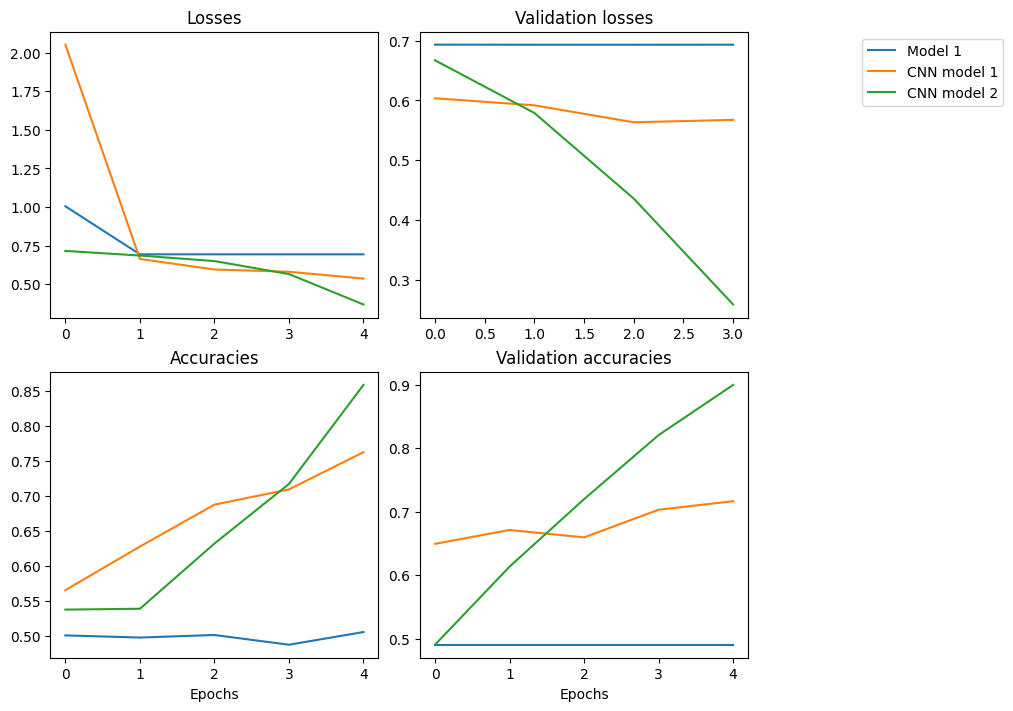

In [17]:
# Visualize learning performance of all models
plot_history(lab_book)

# Model 4:

Until now, we have relied entirely on our own models. A very powerful technique is called **transfer learning**. The concept here is to take a model that has already been trained on a similar dataset and adapt the top layer(s) to your needs.

We will use EfficientNet/B0 (1), a model that has been trained on millions of different images in the [ImageNet database](https://www.image-net.org/). The output layer of EfficientNet/B0 is removed and replaced with our previously used output layer.

---
(1) Tan, M. &amp; Le, Q.. (2019). EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. <i>Proceedings of the 36th International Conference on Machine Learning</i>, in <i>Proceedings of Machine Learning Research</i> 97:6105-6114 Available from https://proceedings.mlr.press/v97/tan19a.html.

In [18]:
# Download the pretrained model and save it as a Keras layer
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
feature_extractor_layer = hub.KerasLayer(efficientnet_url,
                                         trainable=False,
                                         name='feature_extraction_layer',
                                         input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

In [19]:
# Name the model
name = "Transfer learning model 1"

# Build model
tf.random.set_seed(42)
model_4 = keras.Sequential([feature_extractor_layer,
                            layers.Dense(1, activation="sigmoid")
                            ])

model_4.summary()

# Compile CNN model
model_4.compile(loss=keras.losses.BinaryCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit CNN model
history_4 = model_4.fit(train_dataset_10, validation_data=validation_dataset, epochs=5)

# Write lab-book
lab_book[name] = history_4

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 dense_6 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4050845 (15.45 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________
Epoch 1/5
52/52 [==============================] - 28s 200ms/step - loss: 0.4677 - accuracy: 0.8222 - val_loss: 0.3325 - val_accuracy: 0.8890
Epoch 2/5
52/52 [==============================] - 14s 153ms/step - loss: 0.2910 - accuracy: 0.9057 - val_loss: 0.2741 - val_accuracy: 0.8991
Epoch 3/5
52/52 [==============================] - 14s 154m

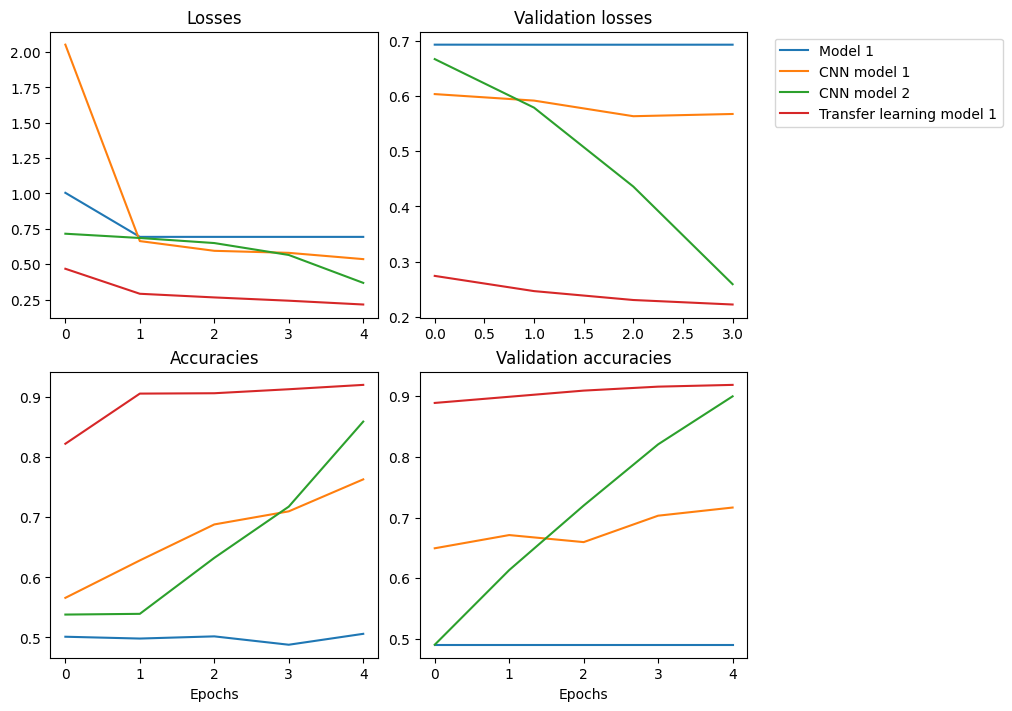

In [20]:
# Visualize learning performance of all models
plot_history(lab_book)

# Time to train our best model on 100% of the training data

In [25]:
# Let's train Feature model 2 on 100% of training data

# Name your model
name = "Transfer learning model full"

# Build CNN model
tf.random.set_seed(42)
model_5 = keras.models.clone_model(model_4)

model_5.summary()

# Compile CNN model
model_5.compile(loss=keras.losses.BinaryCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit CNN model
history_5 = model_5.fit(train_dataset, validation_data=validation_dataset, epochs=5)

# Write lab-book
lab_book[name] = history_5

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 dense_6 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4050845 (15.45 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________
Epoch 1/5
517/517 [==============================] - 45s 68ms/step - loss: 0.2476 - accuracy: 0.9080 - val_loss: 0.1925 - val_accuracy: 0.9351
Epoch 2/5
517/517 [==============================] - 34s 66ms/step - loss: 0.1686 - accuracy: 0.9415 - val_loss: 0.1740 - val_accuracy: 0.9401
Epoch 3/5
517/517 [==============================] - 34s 

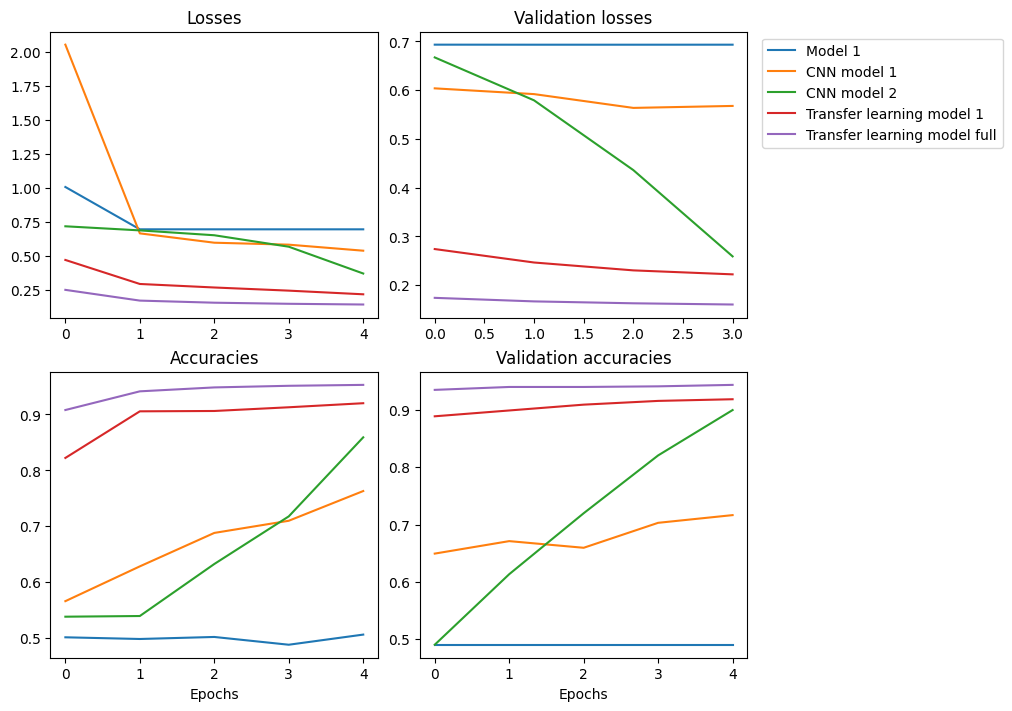

In [26]:
# Visualize learning performance of all models
plot_history(lab_book)

# Final evaluation of all models

**Now we will evaluate all models on the test dataset. This can be considered the final test.**

Depending on the results, the best model can then be deployed for use or for engineering the dataset (e.g., detecting mislabeled images).

259/259 [==============================] - 15s 58ms/step - loss: 0.1433 - accuracy: 0.9475


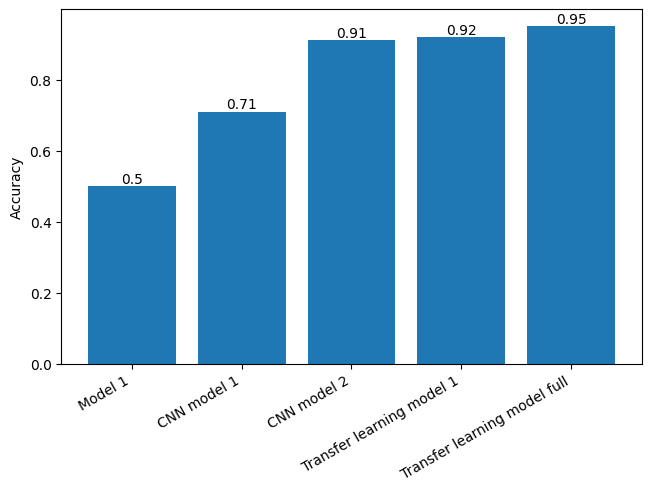

In [27]:
# Evaluate all models on test data
eval = []
for i in range(1,6):
  model_name = "model_" + str(i)
  model_name = globals()[model_name]
  eval.append(model_name.evaluate(test_dataset))

# Transform into a dataframe
results = pd.DataFrame(eval).round(decimals=2)

# Plot a bar plot with accuracy scores
model_names = list(lab_book.keys())
model_accuracies = results[1]

fig, ax = plt.subplots(layout="constrained")
p = ax.bar(x=model_names, height=model_accuracies)
ax.set_ylabel("Accuracy")
plt.xticks(rotation=30, ha="right")
ax.bar_label(p);

# Wrapping Up: Your Neural Network Journey

Congratulations on completing our intensive neural network journey! 🎉 You've absorbed essential concepts that form the foundation of machine learning and neural networks.

**Data's Power**: You've grasped how data's type and format influence neural network performance. Your data shapes the path toward accurate insights.

**Power & Responsibility**: Neural networks are remarkable tools, yet wield them responsibly. Your choices impact outcomes.

**Human vs. Machine Learning**: While neural networks excel at patterns, human learning is enriched by intuition and context. Embrace both, as they complement the evolution of AI.

**You've Done It**: Kudos for tackling this condensed exploration of neural networks! You've equipped yourself with vital knowledge in a short time.

**Future Ventures**: As you step forward, remember the strides you've taken here. Your understanding is a stepping stone to innovation in the world of AI.

---

Best wishes,
Manuel